<a href="https://colab.research.google.com/github/ttogle918/AI_projects/blob/master/sprint2_cinema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie revenue 예측

## 파일 가져오기 및 패키지 정의

In [1]:
# google 드라이브에 로컬 파일 업로드
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import ast
import re
from collections import Counter

In [3]:
import ast
def getDataFrame(s) :
  if s[0] == '\'' :
    s = s[1:-1]
  if str(s)[0] == '{' :
    df = pd.DataFrame([ast.literal_eval(s)])
  if str(s)[0] == '[' :
    df = pd.DataFrame(ast.literal_eval(s))
  else :
    df = s
  return df

In [4]:
credits = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/credits.csv")
keywords = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/keywords.csv")
links = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links.csv")
links = links.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links_small.csv"))
movies_metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/movies_metadata.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings.csv")
ratings = ratings.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings_small.csv"))

credits.shape, keywords.shape, links.shape, movies_metadata.shape, ratings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((45476, 3), (46419, 2), (54968, 3), (45466, 24), (26124293, 4))

|  <center>credit</center> |  <center>cast</center> |
|:--------:|:--------|
|**credit** |cast(id, keywords), crew(credit_id, de), id> |
|**keywords** | id (id, name), keywords(id) |
|**links** | movieId, imdbId, tmdbId |
|**movies_metadata** | adult, belongs_to_collection, budget, genres |
|**''** | homepage, id, imdb_id, original_language |
|**''** | original_title, overview, popularity, poster_path |
|**''** | production_companies, production_countries |
|**''** | release_date, revenue, runtime, spoken_languages |
|**''** | status, tagline, title, video, vote_average, vote_count |
|**ratings** | userId, movieId, rating, timestamp |

## credits : 극 중 등장인물에 대한 정보와 제작진에 대한 정보를 담고있는 dataframe
이 credits의 데이터 중 우리는 배우의 이름과 책임 감독의 이름만 궁금할 것이다.

그러므로 cast에서는 상위 3명(주연), crew에서는 상위 1명(감독 혹은 작가)을 뽑아내었다.
#### 과연 주연과 감독/PD가 영화 판매수익에 영향을 미칠까?

In [5]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


1. data 불러오기
2. 중복된 값 지우기
3. null값, empty값 확인 -> 지우기
4. cast에서 배우 이름 따로 저장, crew에서 감독 이름 따로 저장

In [6]:
credits.duplicated().sum()

37

In [7]:
credits = credits.drop_duplicates()

In [8]:
print('empty cast', len(credits[credits.cast == '[]']) )
print('empty crew', len(credits[credits.crew == '[]']) )

empty cast 2414
empty crew 771


In [9]:
# delete empty cells
credits = credits[(credits.cast != '[]') & (credits.crew != '[]')]
credits.shape

(42675, 3)

In [10]:
print(credits.shape)
print(len(credits['id'].unique())) # id당 한 row가 아니다!

(42675, 3)
42668


In [11]:
# cast의 내용은 같고 credit_id의 값만 다르기 때문에 삭제해도 된다 -> id는 unique()
credits = credits.drop(credits[credits['id'].duplicated() == True].index)
print(credits.shape)
credits.head(3)

(42668, 3)


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


### cast

In [12]:
# string 형태로 data 형태 바꾸기
li = [entry['name'] for entry in  ast.literal_eval(credits.cast[0])[0:4]]
li

['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney']

In [13]:
# cast 상위 8명만
import re

def set_list_to_string(s, idx, to) :
  if to == 0 :
    t_dict = ast.literal_eval(s)
    return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]
  
  t_dict = ast.literal_eval(s)[0:to]
  return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]

In [14]:
credits['actors'] = credits.cast.apply(set_list_to_string, idx='name', to=8)
credits['actors'].head(10)

0    [Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...
1    [Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...
2    [Walter_Matthau, Jack_Lemmon, AnnMargret, Soph...
3    [Whitney_Houston, Angela_Bassett, Loretta_Devi...
4    [Steve_Martin, Diane_Keaton, Martin_Short, Kim...
5    [Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Vo...
6    [Harrison_Ford, Julia_Ormond, Greg_Kinnear, An...
7    [Jonathan_Taylor_Thomas, Brad_Renfro, Rachael_...
8    [JeanClaude_Van_Damme, Powers_Boothe, Dorian_H...
9    [Pierce_Brosnan, Sean_Bean, Izabella_Scorupco,...
Name: actors, dtype: object

In [15]:
# 가장 많이 나온 배우 100명을 most_popular_acctors이라고 가정
from collections import Counter

actor_count = Counter([name for names_per_film in credits.actors.values for name in names_per_film])
most_popular_actors = [entry[0] for entry in actor_count.most_common(100)]
most_popular_actors

['Christopher_Lee',
 'John_Wayne',
 'Jackie_Chan',
 'Gérard_Depardieu',
 'Michael_Caine',
 'Robert_De_Niro',
 'Samuel_L_Jackson',
 'Donald_Sutherland',
 'Danny_Glover',
 'Harvey_Keitel',
 'Christopher_Walken',
 'Susan_Sarandon',
 'Malcolm_McDowell',
 'Anthony_Quinn',
 'John_Hurt',
 'Eric_Roberts',
 'Nicolas_Cage',
 'Morgan_Freeman',
 'John_Goodman',
 'Donald_Pleasence',
 'John_Carradine',
 'Bruce_Willis',
 'Gene_Hackman',
 'Christopher_Plummer',
 'Alec_Baldwin',
 'Steve_Buscemi',
 'Max_von_Sydow',
 'Robert_Duvall',
 'Willem_Dafoe',
 'Vincent_Price',
 'Dennis_Hopper',
 'Keenan_Wynn',
 'Helen_Mirren',
 'Stellan_Skarsgård',
 'Bette_Davis',
 'Liam_Neeson',
 'James_Mason',
 'Woody_Harrelson',
 'James_Caan',
 'John_Leguizamo',
 'James_Stewart',
 'Ed_Harris',
 'John_Turturro',
 'James_Franco',
 'Whoopi_Goldberg',
 'Ben_Kingsley',
 'Robert_Mitchum',
 'Burt_Reynolds',
 'Robin_Williams',
 'Danny_Trejo',
 'John_Cusack',
 'Lionel_Barrymore',
 'Henry_Fonda',
 'Val_Kilmer',
 'Martin_Sheen',
 'Anthon

In [16]:
credits['number_of_named_actors'] = credits['actors'].apply(len)

In [17]:
credits.head(3)

,cast,crew,id,actors,number_of_named_actors
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...",8
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...",8
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter_Matthau, Jack_Lemmon, AnnMargret, Soph...",7


-->>>>> **vectorize가 필요한가/?**

In [18]:
def listToString(item_list):
  return r' '.join(item_list)

credits['actors'] = credits['actors'].apply(listToString)

In [19]:
# import sklearn
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(min_df=50)
# corpus = [word for string in credits['actors'].values for word in string.split(' ')]
# vectorizer.fit(corpus)
# credits['actors_vec'] = credits['actors'].apply(lambda x: [x]).apply(vectorizer.transform)

In [20]:
# credits['actors_vec'][4]

In [21]:
credits.head(3)

,cast,crew,id,actors,number_of_named_actors
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7


### Crew

In [22]:
credits.crew[0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

In [23]:
# [entry['name'] for entry in ast.literal_eval(credits.crew[0])]

In [24]:
credits['crew'] = credits.crew.apply(set_list_to_string, idx='name', to=4)

In [25]:
credits.crew[0]

['John_Lasseter', 'Joss_Whedon', 'Andrew_Stanton', 'Joel_Cohen']

In [26]:
credits['crew'] = credits['crew'].apply(listToString)

In [27]:
credits['number_of_named_crews'] = credits['crew'].apply(len)

In [28]:
credits.head(3)

,cast,crew,id,actors,number_of_named_actors,number_of_named_crews
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...",John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,51
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,59
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,65


In [29]:
# vectorizer = CountVectorizer(min_df=50)
# corpus = [word for string in credits['crew'].values for word in string.split(' ')]
# vectorizer.fit(corpus)
# credits['crews_vec'] = credits['crew'].apply(lambda x: [x]).apply(vectorizer.transform)

In [30]:
# credits['crews_vec'][4]

In [31]:
credits = credits.drop(['cast'], axis=1)

### EDA를 거친 credits 모습

In [32]:
credits.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,51
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,59
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,65


## keywords : 극 중 키워드 단어를 담고있는 dataframe
-> keyword_name에 극 중 키워드 단어를 처리하기 쉬운 형태로 저장한다.

#### 과연 키워드가 영화 판매수익에 영향을 미칠까?

In [33]:
[entry['name'] for entry in  ast.literal_eval(keywords.keywords[0])]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

In [34]:
keywords['keywords'] = keywords.keywords.apply(set_list_to_string, idx='name', to=0)

In [35]:
keywords.head(3)

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board_game, disappearance, based_on_childrens..."
2,15602,"[fishing, best_friend, duringcreditsstinger, o..."


In [36]:
keyword_zip = []
keyword_zip = keyword_zip.append(keywords['keywords'].iloc[1])
print(keyword_zip)

None


In [37]:
keywords['keywords'] = keywords['keywords'].apply(listToString)
keywords.head(3)

,id,keywords
0,862,jealousy toy boy friendship friends rivalry bo...
1,8844,board_game disappearance based_on_childrens_bo...
2,15602,fishing best_friend duringcreditsstinger old_men


In [38]:
keywords['keywords'].unique()

array(['jealousy toy boy friendship friends rivalry boy_next_door new_toy toy_comes_to_life',
       'board_game disappearance based_on_childrens_book new_home recluse giant_insect',
       'fishing best_friend duringcreditsstinger old_men', ...,
       'blair_witch', 'witch mythology legend serial_killer mockumentary',
       'artist play pinoy'], dtype=object)

## credit과 keywords merge

In [39]:
merged_df = pd.merge(credits, keywords, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,51,jealousy toy boy friendship friends rivalry bo...
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,59,board_game disappearance based_on_childrens_bo...
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,65,fishing best_friend duringcreditsstinger old_men


## links : 극 중 키워드 단어를 담고있는 dataframe
-> keyword_name에 극 중 키워드 단어를 처리하기 쉬운 형태로 저장한다.

#### 과연 키워드가 영화 판매수익에 영향을 미칠까?

In [40]:
links.columns = ['movieId', 'imdbId', 'id']
links.head(1)

,movieId,imdbId,id
0,1,114709,862.0


In [41]:
links = links.drop_duplicates()

In [42]:
links.isnull().sum()

movieId      0
imdbId       0
id         222
dtype: int64

## merge


In [43]:
merged_df = pd.merge(merged_df, links, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,movieId,imdbId
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,51,jealousy toy boy friendship friends rivalry bo...,1,114709
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,59,board_game disappearance based_on_childrens_bo...,2,113497
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,65,fishing best_friend duringcreditsstinger old_men,3,113228


## movies_metadata : 영화에 대한 정보를 담고있는 dataframe
-> 예측할 때 필요한 정보만 남겨놓았다.

#### 과연 예산과 장르, 상영시간, 판매회사가 영화 판매수익에 영향을 미칠까?

+ movies_metadata에서 필요없는 컬럼 삭제 ( ['original_language', 'original_title', 'overview', 'poster_path', 'tagline'] )
+ homepage컬럼은 유/무로 판단(있다면 1, 없다면 0)
+ spoken_languages는 언어가 몇가지인지로 적는다. ( 이 영화에 대한 기대감과 투자의 정도를 알 수 있을 것이다. )

In [44]:
movies_metadata.duplicated().sum()

13

In [45]:
movies_metadata = movies_metadata.drop_duplicates()

In [46]:
print(movies_metadata.shape)
movies_metadata.head(2)

(45453, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [47]:
print(movies_metadata.revenue.mean())
print(movies_metadata.revenue.median())
movies_metadata.status.unique()

11212544.046889784
0.0


array(['Released', nan, 'Rumored', 'Post Production', 'In Production',
       'Planned', 'Canceled'], dtype=object)

In [48]:
movies_metadata.isnull().sum()

adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25045
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [49]:
movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [50]:
def toint(s) :
  try :
    n = int(s)
    return n
  except :
    print(s)
    return s
movies_metadata.budget.apply(toint)

/ff9qCepilowshEtG2GYWwzt2bs4.jpg
/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
/zaSf5OG7V8X8gqFvly88zDdRm46.jpg


0        30000000
1        65000000
2               0
3        16000000
4               0
           ...   
45461           0
45462           0
45463           0
45464           0
45465           0
Name: budget, Length: 45453, dtype: object

In [51]:
# 본인의 columns 위치가 아닌 곳에 데이터가 있는 data들 drop
movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/ff9qCepilowshEtG2GYWwzt2bs4.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zaSf5OG7V8X8gqFvly88zDdRm46.jpg'].index)
print(movies_metadata.shape)
movies_metadata.id = movies_metadata.id.astype(int)

(45450, 24)


In [53]:
movies_metadata.poster_path = movies_metadata.poster_path.fillna(0)

In [54]:
def set_poster(s) :
  if s == 0 :
    return 0
  else :
    return 1
  return 0
movies_metadata.poster_path = movies_metadata.poster_path.apply(set_poster)
movies_metadata.columns = ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count']
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count'],
      dtype='object')

In [55]:
print(movies_metadata.adult.unique())
print(movies_metadata.status.unique())
print(movies_metadata.video.unique())

['False' 'True']
['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']
[False True nan]


In [56]:
# False가 대부분이고, True는 극소수(대략 0.02%)이므로 통계적으로 의미를 띄지않는다.(유의미하지않다.) -> drop
Counter(movies_metadata.adult)

Counter({'False': 45441, 'True': 9})

In [57]:
# belongs_to_collection 컬럼에 빈칸(nan)값이 많기 때문에 우리가 예측하고자 하는 바에 도움이 되지 않는다. -> drop
movies_metadata.shape, movies_metadata.belongs_to_collection.isnull().sum()

((45450, 24), 40959)

In [58]:
# Released는 train data로, Planned, In Production, Post Production은 test 데이터로
Counter(movies_metadata.status)

Counter({'Canceled': 2,
         'In Production': 20,
         'Planned': 15,
         'Post Production': 98,
         'Released': 45002,
         'Rumored': 229,
         nan: 84})

In [59]:
# False가 대부분이므로 video feature 삭제
Counter(movies_metadata.video)

Counter({False: 45354, True: 93, nan: 3})

In [60]:
# 1(포스터가 존재)이 대부분이므로 유의미하지 않다.
Counter(movies_metadata.poster)

Counter({0: 386, 1: 45064})

In [61]:
Counter(movies_metadata.homepage) # 대략 1의 비율이 17% -> 남겨둔다.

Counter({'http://toystory.disney.com/toy-story': 1,
         nan: 37673,
         'http://www.mgm.com/view/movie/757/Goldeneye/': 1,
         'http://www.mgm.com/title_title.do?title_star=LEAVINGL': 1,
         'http://www.sevenmovie.com/': 1,
         'http://www.mgm.com/#/our-titles/2083/The-Usual-Suspects': 1,
         'http://www.newline.com/properties/friday.html': 1,
         'http://www.miramax.com/movie/from-dusk-till-dawn/': 1,
         'http://www.nickbroomfield.com/heidifleiss.html': 1,
         'http://www.sonypictures.com/classics/annefrank/index.html': 1,
         'http://miramax.com/movie/blue-in-the-face/': 1,
         'http://www.powerrangers.com/': 1,
         'http://www.strange-days.com': 1,
         'http://www.miramax.com/movie/clerks/': 1,
         'http://www.miramax.com/movie/heavenly-creatures': 1,
         'http://www.starwars.com/films/star-wars-episode-iv-a-new-hope': 1,
         'http://www.miramax.com/movie/like-water-for-chocolate/': 1,
         'http://

In [62]:
len(movies_metadata[ (movies_metadata['revenue'] == 0) ])

38041

In [63]:
movies_metadata[ (movies_metadata['video'] == False) ].revenue

0        373554033.0
1        262797249.0
2                0.0
3         81452156.0
4         76578911.0
            ...     
45461            0.0
45462            0.0
45463            0.0
45464            0.0
45465            0.0
Name: revenue, Length: 45354, dtype: float64

Text(0, 0.5, 'revenue')

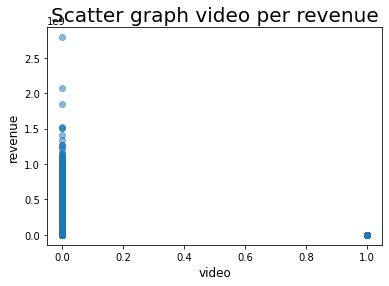

In [64]:
import matplotlib.pyplot as plt
plt.scatter(movies_metadata['video'], movies_metadata['revenue'], alpha = .5)
plt.title('Scatter graph video per revenue', fontsize=20)
plt.xlabel('video', fontsize=12)
plt.ylabel('revenue', fontsize=12)

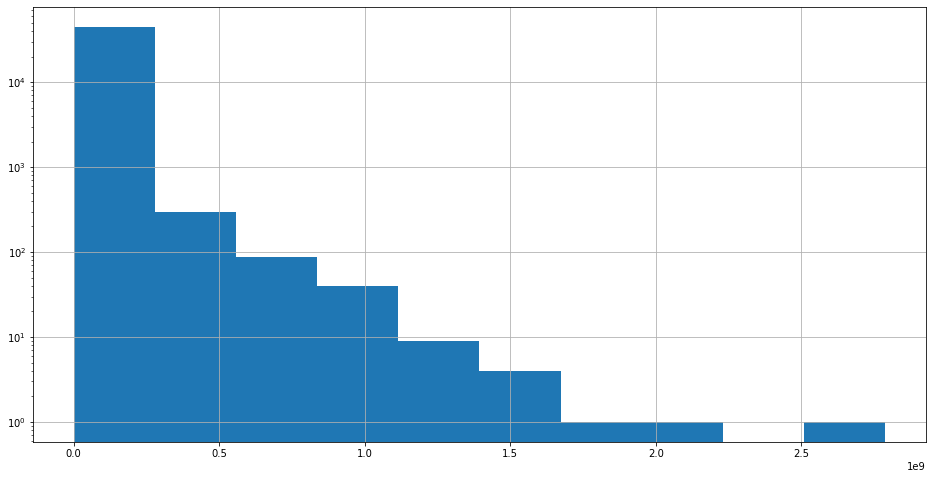

In [65]:
movies_metadata[movies_metadata['video']==False].revenue.hist(figsize=(16,8), log=True);

In [66]:
# 출시 예정 상태의 영화에 대해서 예측할 예정이다. -> 나중에 분리
# test_movies_metadata = movies_metadata[(movies_metadata['status'] == 'Planned') | (movies_metadata['status'] == 'In Production')]
# print(test_movies_metadata.status.unique())

In [67]:
# 출시된 상태의 영화에 대해서 훈련시킬 예정이다.
movies_metadata = movies_metadata[ (movies_metadata['status'] == 'Released') | (movies_metadata['status'] == 'Planned') 
                    | (movies_metadata['status'] == 'In Production') | (movies_metadata['status'] == 'Post Production')]
print(movies_metadata.status.unique())

['Released' 'Post Production' 'In Production' 'Planned']


In [68]:
movies_metadata.describe(include='all')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
count,45135,4478,45135,45135,7750,45135.000000,45120,45125,45135,44210,45135,45135.000000,45135,45135,45053,4.513500e+04,44882.000000,45135,45135,20334,45135,45135,45135.000000,45135.000000
unique,2,1692,1221,4054,7643,NaN,45103,89,43081,44026,43900,NaN,22643,2384,17291,NaN,NaN,1921,4,20211,42009,2,NaN,NaN
top,False,"{'id': 415931, 'name': 'The Bowery Boys', 'pos...",0,"[{'id': 18, 'name': 'Drama'}]",http://www.georgecarlin.com,NaN,tt0157472,en,Hamlet,No overview found.,0.0,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2008-01-01,NaN,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Cinderella,False,NaN,NaN
freq,45126,29,36259,4955,12,NaN,2,32045,8,133,33,NaN,11673,17776,135,NaN,NaN,22284,45002,7,11,45042,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,108644.593043,NaN,NaN,NaN,NaN,NaN,0.991714,NaN,NaN,NaN,1.128934e+07,94.223096,NaN,NaN,NaN,NaN,NaN,5.622282,110.638263
std,NaN,NaN,NaN,NaN,NaN,112782.236077,NaN,NaN,NaN,NaN,NaN,0.090652,NaN,NaN,NaN,6.455644e+07,38.373427,NaN,NaN,NaN,NaN,NaN,1.918346,492.996156
min,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,26279.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000e+00,85.000000,NaN,NaN,NaN,NaN,NaN,5.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,60029.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000e+00,95.000000,NaN,NaN,NaN,NaN,NaN,6.000000,10.000000
75%,NaN,NaN,NaN,NaN,NaN,158419.500000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000e+00,107.000000,NaN,NaN,NaN,NaN,NaN,6.800000,35.000000


imdb_id는 id값이기 때문에 실제 값으로 보기 힘들다. ->drop

vote_count도 count한 통계결과이기 때문에 유의미하지않다. ->drop

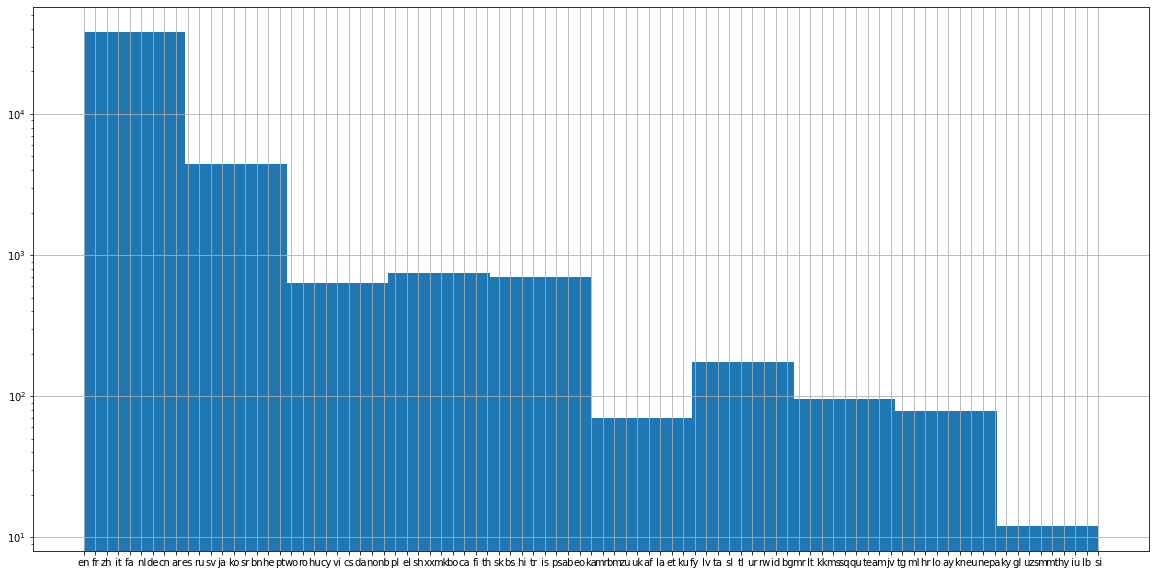

In [69]:
movies_metadata['original_language'].hist(figsize=(20,10), log=True);

In [70]:
movies_metadata = movies_metadata.drop(['adult', 'poster', 'belongs_to_collection', 'imdb_id', 'vote_count', 
                                        'original_language', 'original_title', 'overview', 'tagline', 'video'], axis=1)
movies_metadata.head(2)

,budget,genres,homepage,id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9


In [71]:
movies_metadata['id'] = movies_metadata['id'].astype(int)
movies_metadata['id'].unique()


array([   862,   8844,  15602, ...,  67758, 227506, 461257])

In [72]:
def setHomepage(s) :
  if s == 0 :
    return 0
  s = str(s)
  if s[0:4] == 'http' :
    return 1
  return 0
movies_metadata.fillna(0) # homepage가 없는 경우 0
movies_metadata.homepage = movies_metadata.homepage.apply(setHomepage)

In [73]:
def setLen(s) :
  df = getDataFrame(s)
  n = df.shape[0]
  return n
movies_metadata.spoken_languages = movies_metadata.spoken_languages.apply(setLen)
movies_metadata.spoken_languages.head(5)

0    1
1    2
2    1
3    1
4    1
Name: spoken_languages, dtype: int64

In [74]:
movies_metadata.isnull().sum()

budget                    0
genres                    0
homepage                  0
id                        0
popularity                0
production_companies      0
production_countries      0
release_date             82
revenue                   0
runtime                 253
spoken_languages          0
status                    0
title                     0
vote_average              0
dtype: int64

In [75]:
print(movies_metadata.runtime.min())
print(movies_metadata.runtime.max())
print(len(movies_metadata[movies_metadata.runtime < 60]))

0.0
1256.0
3868


In [76]:
movies_metadata = movies_metadata.drop( movies_metadata[movies_metadata['runtime'] < 60 ].index)
print(movies_metadata.shape)
movies_metadata.head(2)

(41267, 14)


,budget,genres,homepage,id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,862,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,1,Released,Toy Story,7.7
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0,8844,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,2,Released,Jumanji,6.9


## merge

In [77]:
merged_df = pd.merge(merged_df, movies_metadata, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,51,jealousy toy boy friendship friends rivalry bo...,1,114709,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,1,Released,Toy Story,7.7
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,59,board_game disappearance based_on_childrens_bo...,2,113497,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,2,Released,Jumanji,6.9
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,65,fishing best_friend duringcreditsstinger old_men,3,113228,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,1,Released,Grumpier Old Men,6.5


## ratings : 영화에 대한 평점을 담고있는 dataframe
-> 예측할 때 필요한 정보만 남겨놓았다.

#### 과연 ?

In [78]:
ratings = ratings.drop_duplicates(ignore_index=True)  # 중복값 없음
print(ratings.shape)

(26124293, 4)


In [79]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [80]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


In [81]:
ratings = ratings.drop(['userId', 'timestamp'], axis=1)
ratings['rating'].unique()

array([1. , 4.5, 5. , 4. , 3.5, 2.5, 0.5, 3. , 2. , 1.5])

In [82]:
grouped_rating = (ratings.groupby(by="movieId").mean())['rating'].to_frame()
grouped_rating['rating'] = grouped_rating['rating'].round(1)
grouped_rating = grouped_rating.reset_index()
# grouped_rating.columns = ['id', 'rating']

grouped_rating.head(3)

,movieId,rating
0,1,3.9
1,2,3.2
2,3,3.2


## merge

In [83]:
merged_df = pd.merge(merged_df, grouped_rating, how='inner', on='movieId')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,rating
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,51,jealousy toy boy friendship friends rivalry bo...,1,114709,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,1,Released,Toy Story,7.7,3.9
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,59,board_game disappearance based_on_childrens_bo...,2,113497,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,2,Released,Jumanji,6.9,3.2
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,65,fishing best_friend duringcreditsstinger old_men,3,113228,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,1,Released,Grumpier Old Men,6.5,3.2


## 학습하기 좋은 데이터 모양으로 만들기
1. unique 데이터(ex. id) drop
2. train과 test data 나누기

In [84]:
# merged_df = merged_df.drop(['id', 'movieId', 'imdbId'], axis=1)
merged_df.shape

(39861, 22)

In [85]:
merged_df[merged_df['release_date'].isnull()==True].head(1)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,rating
713,John_OBrien John_OBrien,215107,George_Thrush Marya_Cohn Ann_OBrien,3,23,,752,105737,0,[],0,0.75,[],[],NaN,0.0,88.0,0,Released,Vermont Is for Lovers,0.0,2.9


In [86]:
# merged_df[merged_df['vote_'].isnull()==True]


In [87]:
# test data가 너무 부족하다 -> movies_metadata[movies_metadata['release_date'] > '2016-01-01']
final_test = merged_df[merged_df['status'] != 'Released']
train = merged_df[merged_df['status'] == 'Released']
print(train.shape)
print(final_test.shape)

(39756, 22)
(105, 22)


In [88]:
print(train['vote_average'].dtype)

len(train[train['vote_average'] == 0])

float64


1741

In [89]:
print(train['rating'].dtype)

len(train[train['rating'] == 0])

float64


0

In [90]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)

### corr는 선형적 의미
https://gomguard.tistory.com/173

In [91]:
import seaborn as sns
corr = merged_df.corr()
corr['rating']
df_target_corr = corr[['rating']].sort_values('rating', ascending=False)
df_target_corr

,rating
rating,1.000000
vote_average,0.362285
runtime,0.159481
spoken_languages,0.077511
revenue,0.065782
homepage,0.061452
number_of_named_crews,0.052008
imdbId,-0.011374
number_of_named_actors,-0.024590
id,-0.064633


In [92]:
# vote_count == 0  지우기.
# production_countries 지우기 -> 상관계수에 안나옴
# crew 안나옴 지우자
# actors 안나옴 -> 지우자
# budget == 0 이 많은가? 상관계수 안뜸
# genres 고쳐야함
# poster 없앨까... 0.008?
# released data 없애자.
# title 없애자

In [93]:
target = 'rating'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_train.shape, X_val.shape, X_test.shape

((25443, 21), (6361, 21), (7952, 21))